In [1]:
import pandas as pd

# plotting modules
import matplotlib.colors as colors
import seaborn as sns
from matplotlib.ticker import MultipleLocator
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = "Arial" # missing fonts:: https://alexanderlabwhoi.github.io/post/2021-03-missingfont/
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams.update({'font.size': 14, 'axes.linewidth': 2, 'xtick.major.width': 1.5, 'xtick.major.size': 5, 'ytick.major.width': 1.5, 'ytick.major.size': 4})
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
def save_pdf(save_file, fig):
    pdf = PdfPages(save_file)
    pdf.savefig(fig, bbox_inches='tight')
    pdf.close()
    return

In [3]:
meta_file = "../data/meta_activity_map.csv"

In [4]:
meta_df = pd.read_csv(meta_file)

In [5]:
ko_lines = ["ATF2", "CTCF", "FOXA1", "LEF1", "SCRT1", "TCF7L2", "16P12_1"]

In [6]:
def get_gained_fragments(meta_df, ko):
    meta_df[f"{ko}_induced"] = ((meta_df[f"{ko}_log2FoldChange"]>0)&(meta_df[f"{ko}_padj"]<0.01)&(meta_df[f"{ko}_peak"]==1)).astype(int)
    meta_df_gained = meta_df.loc[(meta_df[f"{ko}_induced"]==1)&(meta_df[f"CC_peak"]==0)]
    return meta_df_gained

def get_lost_fragments(meta_df, ko):
    meta_df[f"{ko}_repressed"] = ((meta_df[f"{ko}_log2FoldChange"]<0)&(meta_df[f"{ko}_padj"]<0.01)&(meta_df[f"{ko}_peak"]==0)).astype(int)
    meta_df_lost = meta_df.loc[(meta_df[f"{ko}_repressed"]==1)&(meta_df[f"CC_peak"]==1)]
    return meta_df_lost

In [7]:
def create_ko_df(meta_df, ko_lines):
    data_dict = {f"{ko}":[] for ko in ko_lines}
    for ko in ko_lines:
        gained_fragments = get_gained_fragments(meta_df, ko)
        lost_fragment = get_lost_fragments(meta_df, ko)
        data_dict[ko].append(len(gained_fragments))
        data_dict[ko].append(len(lost_fragment))
    df = pd.DataFrame(data=data_dict, columns=ko_lines, index=["gained", "lost"])
    return df


In [8]:
gain_loss_df = create_ko_df(meta_df, ko_lines).T.reset_index().rename(columns={'index': 'TF'})

In [9]:
plot_df = gain_loss_df.loc[gain_loss_df.TF!="16P12_1"].melt(id_vars=["TF"], value_vars=["gained", "lost"], var_name="Activity", value_name="Fragment count")

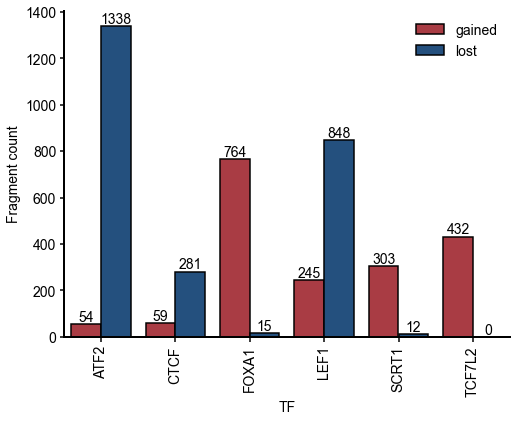

In [10]:
fig, axes = plt.subplots(figsize=(8,6))

g = sns.barplot(
    data=plot_df, x="TF", y="Fragment count", 
    hue="Activity", palette=["#bb2a34", "#15508d"], hue_order=["gained", "lost"],  #
    log=False, ax=axes, edgecolor="k", linewidth=1.5)

g.axes.set_xticklabels(g.axes.get_xticklabels(), rotation=90)

for i in g.containers:
    g.bar_label(i,);

axes.spines[["right", "top"]].set_visible(False)
axes.legend(frameon=False)

In [11]:
save_file = "../data/figures/gain_loss.pdf"
save_pdf(save_file, fig)